In [20]:
#Loading data
import pandas as pd
import dask.dataframe as dd
import time
import tensorflow as tf
import pathlib

text = tf.keras.utils.get_file(
fname = "fra-eng.zip", 
origin = "http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
extract = True)

data_size = 20000

text = pathlib.Path(text).parent / "fra.txt"
f = open(text, "r").read()
f = f.split("\n")[:data_size]
english = []; french = []
for data in f:
    english.append(data.split('	')[0])
    french.append(data.split('	')[1])

df_full = pd.DataFrame({"en" : english, "fr" : french})
df_full.head()

,en,fr
0,Go.,Va !
1,Hi.,Salut !
2,Run!,Cours !
3,Run!,Courez !
4,Who?,Qui ?


In [21]:
#Looking at data
import numpy as np
import matplotlib.pyplot as plt
import re

#Standardize
df = df_full[:data_size]
df = df.dropna()

def preprocess(word):
    word = word.lower()
    to_strip = "._!@#$%^&*|\?/<>[]-()"
    for char in to_strip:
        word = word.replace(char, '')
    word = re.sub(r'\d', 'N', word)
    return word

df.en = [preprocess(word) for word in df.en.tolist()]
df.fr = [preprocess(word) for word in df.fr.tolist()]



print(f"Shape: {df.shape}")

#Looking at random words
'''for _ in range(0, 5):
    idx = np.random.randint(0, df.shape[0])
    print(f"EN: {df.en[idx]}\n FR: {df.fr[idx]} \n\n")'''

#Fixing word lengths
en_wlen = [len(i) for i in df.en]
fr_wlen = [len(i) for i in df.fr]
print(f"English: mean = {np.mean(en_wlen)}, std = {np.std(en_wlen)}, max = {np.max(en_wlen)}, min = {np.min(en_wlen)}")
print(f"France: mean = {np.mean(fr_wlen)}, std = {np.std(fr_wlen)}, max = {np.max(fr_wlen)}, min = {np.min(fr_wlen)}")

to_drop = []
for idx in df.index:
    if len(df.en[idx]) < 5 or len(df.en[idx]) > np.mean(en_wlen) + np.std(en_wlen):
        to_drop.append(idx)
    elif len(df.fr[idx]) < 5 or len(df.fr[idx]) > np.mean(fr_wlen) + np.std(fr_wlen):
        to_drop.append(idx)
        
df = df.drop(to_drop, axis = 0)
print(f"Shape: {df.shape}")


#Looking at random words again
for _ in range(0, 5):
    idx = np.random.choice(df.index)
    print(f"EN: {df.en[idx]}\n FR: {df.fr[idx]} \n\n")


Shape: (20000, 2)
English: mean = 14.08545, std = 2.3816902186262596, max = 17, min = 2
France: mean = 18.9336, std = 5.600570599501448, max = 56, min = 3
Shape: (14938, 2)
EN: they laughed
 FR: ils ont ri 


EN: i let you down
 FR: je t'ai laissée tomber 


EN: stay right there
 FR: reste juste là  


EN: grow up a little
 FR: grandissez un peu 


EN: they look sad
 FR: ils ont l'air triste 




In [22]:
#Finding good amount of tokens to use 
import tensorflow as tf

MAX_SEQLEN = 20
print(f"MAX SEQLEN: {MAX_SEQLEN}")

MAX_EN = 10000
en_vectorizer = tf.keras.layers.TextVectorization(standardize = 'lower_and_strip_punctuation', output_sequence_length = MAX_SEQLEN, max_tokens = MAX_EN)
en_vectorizer.adapt(df.en)
print(f"EN Vocab: Size = {len(en_vectorizer.get_vocabulary())}, Least Common = {en_vectorizer.get_vocabulary()[-10:]}")

MAX_FR = 20000
fr_vectorizer = tf.keras.layers.TextVectorization(standardize = 'lower_and_strip_punctuation', output_sequence_length = MAX_SEQLEN, max_tokens = MAX_FR)
fr_vectorizer.adapt(df.fr)
print(f"FR Vocab: Size = {len(fr_vectorizer.get_vocabulary())}, Least Common = {fr_vectorizer.get_vocabulary()[-10:]}")

MAX SEQLEN: 20
EN Vocab: Size = 2924, Least Common = ['accessible', 'acceptable', 'accept', 'absurd', 'absent', 'above', 'abhor', 'abducted', 'abandoned', 'abandon']
FR Vocab: Size = 6281, Least Common = ['aboyaitil', 'aboyait', 'aboya', 'aboie', 'abattue', 'abattu', 'abasourdi\u202f', 'abandonne\u202f', 'abandonnez', 'abandonna']


In [23]:
#Preparing data and training
fr_x = ["sos " + text for text in df.fr.tolist()]
fr_y = [text + " eos" for text in df.fr.tolist()]

en = en_vectorizer(df.en).numpy()

n_slices = 6
val_start = (n_slices - 2) * (df.shape[0] // n_slices)
test_start = (n_slices - 1) * (df.shape[0] // n_slices)

en_train = en[:val_start]; en_val = en[val_start:test_start]; en_test = en[test_start:]
fr_x_train = fr_x[:val_start]; fr_x_val = fr_x[val_start:test_start]; fr_x_test = fr_x[test_start:]
fr_y_train = fr_y[:val_start]; fr_y_val = fr_y[val_start:test_start]; fr_y_test = fr_y[test_start:]

fr_vectorizer.adapt(fr_x_train + fr_y_train)
fr_x_train = fr_vectorizer(fr_x_train).numpy(); fr_y_train = fr_vectorizer(fr_y_train).numpy(); 
fr_x_test = fr_vectorizer(fr_x_test).numpy(); fr_y_test = fr_vectorizer(fr_y_test).numpy(); 
fr_x_val = fr_vectorizer(fr_x_val).numpy(); fr_y_val = fr_vectorizer(fr_y_val).numpy()


MAX_EN = len(en_vectorizer.get_vocabulary())
MAX_FR = len(fr_vectorizer.get_vocabulary())

In [24]:
#Transformer custom layers

class PositionalEmbedding1D(tf.keras.layers.Layer):
    def __init__(self, embedding_size, vocab_size, sequence_length):
        super().__init__()
        self.embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.positional_encoding = []
        for pos in range(0, sequence_length):
            encoding = []
            for i in range(0, embedding_size):
                if i%2 == 0:
                    encoding.append(np.sin(pos/np.power(10000, 2*i/embedding_size)))
                else:
                    encoding.append(np.cos(pos/np.power(10000, 2*i/embedding_size)))
            self.positional_encoding.append(np.array(encoding))
        self.positional_encoding = tf.constant(self.positional_encoding)
        
    def call(self, input):
        embedding = self.embedding_layer(input)
        positional_embedding = embedding + tf.cast(self.positional_encoding, tf.float32)
        return positional_embedding
        


class AttentionBlock(tf.keras.layers.Layer):
    def __init__(self, query_key_size, value_size, n_heads, dense_units, n_dense_layers, use_mask, **kwargs):
        super().__init__()
        self.multihead_attention = tf.keras.layers.MultiHeadAttention(n_heads, query_key_size, value_dim = value_size, kernel_regularizer = tf.keras.regularizers.L2(0.02))
        self.dense_units = dense_units
        self.use_mask = use_mask
        self.n_dense_layers = n_dense_layers
        self.first_dense_layer = tf.keras.layers.Dense(query_key_size, activation = 'relu')
        if n_dense_layers > 1:
            self.dense_stack = [tf.keras.layers.Dense(dense_units) for _ in range(n_dense_layers - 1)]
        else:
            self.dense_stack = []
        self.add = tf.keras.layers.Add()
        self.norm = tf.keras.layers.LayerNormalization()
        self.dropout = tf.keras.layers.Dropout(0.2)
    
    def call(self, query, key, value):
        attention = self.multihead_attention(query = query, key = key, value = value, use_causal_mask = self.use_mask)
        add = self.add([attention, query])
        add_norm_1 = self.norm(add)
        add_norm_1 = self.dropout(add_norm_1)
        if self.n_dense_layers == 0:
            return add_norm_1
        else:
            feed_forward = self.first_dense_layer(add_norm_1)
            if len(self.dense_stack) != 0:
                for dense in self.dense_stack:
                    feed_forward = dense(feed_forward)
            add2 = self.add([add_norm_1, feed_forward])
            add_norm_2 = self.norm(add2)
            add_norm_2 = self.dropout(add_norm_2)
            return add_norm_2

In [25]:
#Creating the model out of these components

hidden_dim = 512
dense_units = 1024
heads = 8

encoder_input = tf.keras.layers.Input(shape = [MAX_SEQLEN, ])
encoder_positional_encodings = PositionalEmbedding1D(sequence_length = MAX_SEQLEN, vocab_size = MAX_EN, embedding_size = hidden_dim)(encoder_input)
encoder_output = AttentionBlock(query_key_size = hidden_dim, value_size = hidden_dim, n_heads = heads, dense_units = dense_units, n_dense_layers = 1, use_mask = False)(query = encoder_positional_encodings, key = encoder_positional_encodings, value = encoder_positional_encodings)

decoder_input = tf.keras.layers.Input(shape = [MAX_SEQLEN, ])
decoder_positional_encodings = PositionalEmbedding1D(sequence_length = MAX_SEQLEN, vocab_size = MAX_FR, embedding_size = hidden_dim)(decoder_input)
decoder_self = AttentionBlock(query_key_size = hidden_dim, value_size = hidden_dim, n_heads = heads, dense_units = dense_units, n_dense_layers = 0, use_mask = True)(query = decoder_positional_encodings, key = decoder_positional_encodings, value = decoder_positional_encodings)
decoder_cross = AttentionBlock(query_key_size = hidden_dim, value_size = hidden_dim, n_heads = heads, dense_units = dense_units, n_dense_layers = 1, use_mask = False)(query = decoder_self, key = encoder_output, value = encoder_output)

output = tf.keras.layers.Dense(MAX_FR)(decoder_cross)
'''output = tf.keras.layers.Lambda(lambda x : x / 1.5)(output) #Temperature'''
output = tf.keras.layers.Activation('softmax')(output)

model = tf.keras.models.Model((encoder_input, decoder_input), output)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'attention_block_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 20, 512)   │  1,497,088 │ input_layer_4[0]… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 20, 512)   │  2,448,896 │ input_layer_5[0]… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_block_6   │ (None, 20, 512)   │  8,665,088 │ positional_embed… │
│ (AttentionBlock)    │                   │            │ positional_embed… │
│                     │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_block_7   │ (None, 20, 512)   │  8,402,432 │ positional_embed… │
│ (AttentionBlock)    │                   │            │ positional_embed… │
│                     │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_block_8   │ (None, 20, 512)   │  8,665,088 │ attention_block_… │
│ (AttentionBlock)    │                   │            │ attention_block_… │
│                     │                   │            │ attention_block_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 20, 4783)  │  2,453,679 │ attention_block_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 20, 4783)  │          0 │ dense_11[0][0]    │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,132,271 (122.57 MB)

 Trainable params: 32,132,271 (122.57 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
#Compiling with custom scheduler and loss

class TransformerLRScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d, warmup_steps):
        super().__init__()
        self.d = tf.cast(d, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        return (1/tf.sqrt(self.d)) * tf.minimum(1/tf.sqrt(self.d), step/(self.warmup_steps * tf.sqrt(self.warmup_steps)))
    

def masked_loss(y_true, y_pred):
    mask = tf.not_equal(y_true, 0)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction = 'none')(y_true, y_pred)
    mask = tf.cast(mask, loss.dtype)
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)


def masked_accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32); y_pred = tf.cast(y_true, tf.float32)
    mask = tf.not_equal(y_true, 0)
    accuracy = tf.cast(y_true, tf.float32) == tf.cast(y_pred, tf.float32)
    accuracy = tf.boolean_mask(accuracy, mask)
    avg_accuracy = tf.reduce_sum(tf.cast(accuracy, tf.float32)) / tf.reduce_sum(tf.cast(mask, tf.float32))
    return avg_accuracy
    
model.compile(optimizer = tf.keras.optimizers.Adam(TransformerLRScheduler(hidden_dim, 4000.0)), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

Epoch 1/20
  5/312 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.0000e+00 - loss: 42.0662  

W0000 00:00:1720383936.615497     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5285 - loss: 35.3366

W0000 00:00:1720383960.379672     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


312/312 ━━━━━━━━━━━━━━━━━━━━ 46s 90ms/step - accuracy: 0.5291 - loss: 35.3140 - val_accuracy: 0.7878 - val_loss: 14.6022
Epoch 2/20
  5/312 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.8065 - loss: 14.4225

W0000 00:00:1720383964.469914     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8298 - loss: 9.7144 - val_accuracy: 0.8289 - val_loss: 2.0578
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8567 - loss: 1.4503 - val_accuracy: 0.8417 - val_loss: 1.2122
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8619 - loss: 0.9986 - val_accuracy: 0.8487 - val_loss: 1.1167
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8682 - loss: 0.9047 - val_accuracy: 0.8510 - val_loss: 1.1072
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8713 - loss: 0.8451 - val_accuracy: 0.8524 - val_loss: 1.0628
Epoch 7/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8735 - loss: 0.7951 - val_accuracy: 0.8522 - val_loss: 1.0674
Epoch 8/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8738 - loss: 0.7596 - val_accuracy: 0.8524 - val_loss: 1.1047
Epoch 9/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8632 - loss: 1.0452 - val_accuracy: 0.851

[1.2486356496810913, 0.8434616923332214]

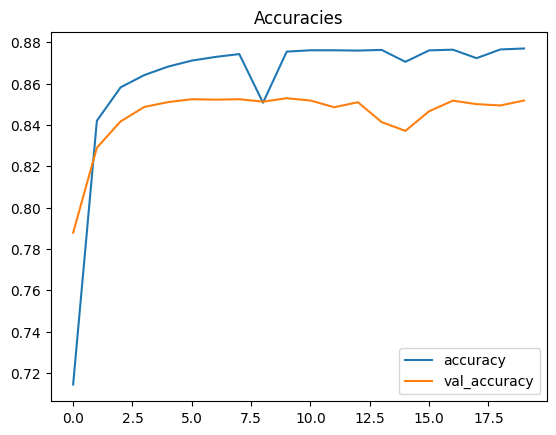

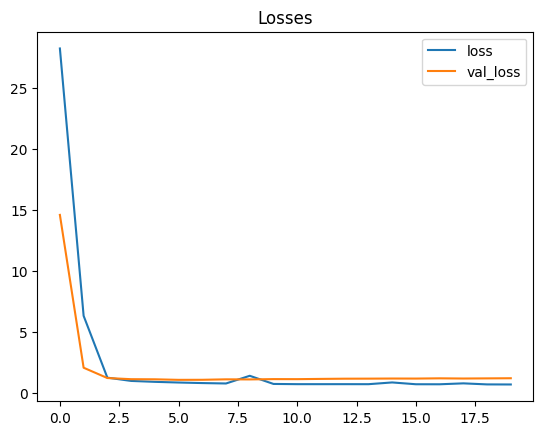

In [27]:
#Running transformer

hist = model.fit((en_train, fr_x_train), fr_y_train, epochs = 20, validation_data = ((en_val, fr_x_val), fr_y_val)).history
pd.DataFrame(hist)[['accuracy', 'val_accuracy']].plot(title = "Accuracies")
pd.DataFrame(hist)[['loss', 'val_loss']].plot(title = "Losses")

model.evaluate((en_test, fr_x_test), fr_y_test)

In [28]:
#Random predictions

def rand_pred(en_data, fr_data, K):
    idx = np.random.randint(0, en_data.shape[0])
    en_vect = en_data[idx]; en = " ".join([en_vectorizer.get_vocabulary()[i] for i in en_vect if i != 0])
    fr_vect = fr_data[idx]; fr = " ".join([fr_vectorizer.get_vocabulary()[i] for i in fr_vect if i != 0]).replace("sos ", "")
    print(f"{en} => {fr}")

    output = "sos"
    wlen = 1
    while "eos" not in output and wlen < 50:
        in_vect = fr_vectorizer(output)
        pred_vect = model.predict((np.expand_dims(en_vect, 0), np.expand_dims(in_vect, 0)), verbose = 0)[0][0]
        output += " " + fr_vectorizer.get_vocabulary()[np.argmax(pred_vect)]
        wlen += 1

    print(output)
    
rand_pred(en_test, fr_x_test, K = 5)

i dont mean you => je ne veux pas dire toi


W0000 00:00:1720384147.234682     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


sos je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je
